In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking, GRU
import numpy as np
import keras
#from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from numpy import load
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K


np.random.seed(1337)# setting the random seed value

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/train_data/ILDC_multi.csv')
x_train0 = load("/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/CaseLawBERT_bigru_att_full/CaseLawBERT_npy_files_cls_multi_full/CaseLawBERT_cls_train.npy", allow_pickle = True)
x_dev0 = load("/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/CaseLawBERT_bigru_att_full/CaseLawBERT_npy_files_cls_multi_full/CaseLawBERT_cls_dev.npy", allow_pickle= True)
x_test0 = load("/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/only_annotation/compute_embs_anno/CaseLawBERT_npy_files_cls_multi_anno/CaseLawBERT_cls_test_anno_full.npy", allow_pickle= True)

In [4]:
l=[]
for i in range(len(x_test0)):
  l.append(len(x_test0[i]))

In [5]:
print(l)

[6, 13, 6, 7, 7, 1, 7, 5, 4, 14, 6, 9, 9, 4, 8, 3, 8, 5, 9, 4, 5, 3, 3, 7, 21, 13, 8, 6, 15, 7, 5, 9, 11, 5, 8, 5, 15, 10, 11, 11, 10, 6, 18, 3, 5, 5, 5, 15, 4, 25, 5, 5, 25, 3, 14, 3]


In [6]:
# loading the corresponding label for each case in dataset
dev = dataset.loc[dataset['split'] == 'dev']
train = dataset.loc[dataset['split'] == 'train']

y_train0 = []
for i in range(train.shape[0]):
    y_train0.append(train.loc[i,'label'])

y_dev0 = []
for i in range(dev.shape[0]):
    y_dev0.append(dev.loc[i+32305,'label'])

In [7]:
test = pd.read_csv('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation/ILDC_expert/anno_dataset.csv')
y_test0 = list(test['label'])

In [8]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


In [9]:
class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=200,return_coefficients=False,**kwargs):
        # Initializer
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def _get_attention_weights(self, X):

        u_tw = K.tanh(K.dot(X, self.W))
        tw_stimulus = K.dot(u_tw, self.u)

        # Remove the last axis an apply softmax to the stimulus to
        # get a probability.
        tw_stimulus = K.squeeze(tw_stimulus, -1)
        tw_stimulus = K.exp(tw_stimulus)


        tw_stimulus /= K.cast(K.sum(tw_stimulus, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        att_weights = K.expand_dims(tw_stimulus)
        return att_weights

    def call(self, hit, mask=None):
        att_weights = self._get_attention_weights(hit)

        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)

        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait

        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):

        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

In [10]:
from keras import layers
# Input layer to convert into required tensor shape
text_input = Input(shape=(None,768,), dtype='float32', name='text')
# Masking layer to mask the padded values
l_mask = layers.Masking(mask_value=-99.)(text_input)
# After masking we encoded the vector using 2 bidirectional GRU's
encoded_text = layers.Bidirectional(GRU(100,return_sequences=True))(l_mask)
encoded_text1 = layers.Bidirectional(GRU(100,return_sequences=True))(encoded_text)
# Then we add the Attention Layer which we created above
sent_att,sent_coeffs, = AttentionLayer(200,return_coefficients=True,name='sent_attention')(encoded_text1)
# Add a dropout layer
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
# Added a dense layer after encoding
out1 = layers.Dense(30, activation='relu')(sent_drop)
# And we add a sigmoid classifier on top
out = layers.Dense(1, activation='sigmoid')(out1)
model = Model(text_input,out)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 200)         522000    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 200)         181200    
 onal)                                                           
                                                                 
 sent_attention (AttentionL  [(None, 200),             40400     
 ayer)                        (None, None, 1)]                   
                                                             

In [11]:
num_sequences = len(x_train0)
batch_size = 32
batches_per_epoch =  int(num_sequences/batch_size)
num_features= 768
def train_generator(): # function to generate batches of corresponding batch size
    x_list= x_train0
    y_list =  y_train0
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(x_train0[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole training data
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [12]:
num_sequences_val = len(x_dev0)
batch_size_val = 32
batches_per_epoch_val = int(num_sequences_val/batch_size_val)
num_features= 768
def val_generator(): # Similar function to generate validation batches
    x_list= x_dev0
    y_list =  y_dev0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(x_dev0[:(b + 1) * batch_size_val][-batch_size_val:], key=len))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            # padding the vectors with respect to the maximum sequence of each batch and not the whole validation data
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [13]:
# compiling the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [14]:
# Setting the callback and training the model
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=2, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=2,
                    validation_data=val_generator(), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/2


<ipython-input-14-d54a78899f6a>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator(), steps_per_epoch=batches_per_epoch, epochs=2,


1009/1009 [==============================] - 59s 33ms/step - loss: 0.3017 - acc: 0.8794 - val_loss: 0.5929 - val_acc: 0.7480 - lr: 0.0010
Epoch 2/2
1009/1009 [==============================] - 29s 29ms/step - loss: 0.2858 - acc: 0.8849 - val_loss: 0.5815 - val_acc: 0.7560 - lr: 0.0010


In [15]:
num_sequences_test = len(x_test0)
batch_size_test = 16
batches_per_epoch_test = int(num_sequences_test/batch_size_test)
num_features= 768
def test_generator(): # function to generate batches of corresponding batch size
    x_list= x_test0
    y_list =  y_test0
    # Generate batches
    while True:
        for b in range(batches_per_epoch_test):
            if(b == batches_per_epoch_test-1): # An extra if else statement just to manage the last batch as it's size might not be equal to batch size
              longest_index = num_sequences_test - 1
              timesteps = len(max(x_test0[:longest_index + 1][-batch_size_test:], key=len))
              x_train = np.full((longest_index - b*batch_size_test, timesteps, num_features), -99.)
              y_train = np.zeros((longest_index - b*batch_size_test,  1))
              for i in range(longest_index - b*batch_size_test):
                  li = b * batch_size_test + i
                  x_train[i, 0:len(x_list[li]), :] = x_list[li]
                  y_train[i] = y_list[li]
            else:
                longest_index = (b + 1) * batch_size_test - 1
                timesteps = len(max(x_test0[:(b + 1) * batch_size_test][-batch_size_test:], key=len))
                x_train = np.full((batch_size_test, timesteps, num_features), -99.)
                y_train = np.zeros((batch_size_test,  1))
                # padding the vectors with respect to the maximum sequence of each batch and not the whole test data
                for i in range(batch_size_test):
                    li = b * batch_size_test + i
                    x_train[i, 0:len(x_list[li]), :] = x_list[li]
                    y_train[i] = y_list[li]
            yield x_train, y_train


In [16]:
# evaluating on the test data
model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)

<ipython-input-16-8e91bbf97f2e>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator(), steps= batches_per_epoch_test)


[0.9064233303070068, 0.6727272868156433]

In [17]:
# defining a function which calculates various metrics such as micro and macro precision, accuracy and f1
def metrics_calculator(preds, test_labels):
    cm = confusion_matrix(test_labels, preds)
    TP = []
    FP = []
    FN = []
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[i][j]

        FN.append(summ)
    for i in range(0,2):
        summ = 0
        for j in range(0,2):
            if(i!=j):
                summ=summ+cm[j][i]

        FP.append(summ)
    for i in range(0,2):
        TP.append(cm[i][i])
    precision = []
    recall = []
    for i in range(0,2):
        precision.append(TP[i]/(TP[i] + FP[i]))
        recall.append(TP[i]/(TP[i] + FN[i]))

    macro_precision = sum(precision)/2
    macro_recall = sum(recall)/2
    micro_precision = sum(TP)/(sum(TP) + sum(FP))
    micro_recall = sum(TP)/(sum(TP) + sum(FN))
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision + macro_recall)
    return macro_precision, macro_recall, macro_f1, micro_precision, micro_recall, micro_f1

In [18]:
# getting the predicted labels on the test data
preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)
y_pred = preds > 0.5

# Calculating all metrics on test data predicted label
print(metrics_calculator(y_pred, y_test0[:-1]))

<ipython-input-18-129cc16c0af6>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator(), steps= batches_per_epoch_test)


(0.6996996996996997, 0.6759259259259259, 0.6876073818042164, 0.6727272727272727, 0.6727272727272727, 0.6727272727272727)


In [ ]:
#model.evaluate(val_generator(), steps= batches_per_epoch_val)

In [19]:
# getting the predicted labels on the dev data
preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)
y_pred_dev = preds > 0.5

# Calculating all metrics on dev data predicted label
print(metrics_calculator(y_pred_dev, y_dev0[:-2]))

<ipython-input-19-1a0ce2dc0e38>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(val_generator(), steps= batches_per_epoch_val)


(0.7668971595146092, 0.7560483870967742, 0.7614341324418619, 0.7560483870967742, 0.7560483870967742, 0.7560483870967742)


In [20]:
# saving the trained model
model.save('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/only_annotation/attention_anno_full/BIGRU_Attention_caselawbert_anno_full.h5')  # creates a HDF5 file 'BIGRU_Attention_XLNet.h5'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# getting the self attention layer from the trained model and creating a new model with that layer to get attention weights
att_layer = model.get_layer('sent_attention') #  recupera lo strato di autoattenzione chiamato 'sent_attention' dal modello esistente
prev_tensor = att_layer.input #  viene ottenuto il tensore di input dell'autoattenzione att_layer, rappresenta i dati di input dell'autoattenzione.

#Qui viene creato uno strato dummy (fittizio) utilizzando Lambda per calcolare i pesi di attenzione dell'autoattenzione. La funzione lambda prende
# il tensore prev_tensor come input e richiama il metodo _get_attention_weights dell'autoattenzione (att_layer) per ottenere i pesi di attenzione.
dummy_layer = Lambda(lambda x: att_layer._get_attention_weights(x))(prev_tensor)

# viene creato un nuovo modello chiamato model2. text_input è un tensore che rappresenta i dati di input del modello originale, dummy_layer è lo strato
# dummy creato nella riga precedente, che restituisce i pesi di attenzione. In questo modo, model2 è stato costruito per accettare lo stesso input del
# modello originale ma produce un output che sono i pesi di attenzione calcolati dall'autoattenzione.
model2 = Model(text_input, dummy_layer)
model2.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'sent_attention/W:0' shape=(200, 200) dtype=float32>
  <tf.Variable 'sent_attention/u:0' shape=(200, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, None, 768)]       0         
                                                                 
 masking (Masking)           (None, None, 768)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 200)         522000    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 200)         181200    
 onal)                                                           
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 703200 (2.68 MB)
Trainable params: 703200 (2.

In [22]:
model2.save('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/only_annotation/attention_anno_full/BIGRU_Attention_caselawbert_anno_full_model2.h5')  # creates a HDF5 file 'BIGRU_Attention_XLNet.h5'

In [23]:
wt_vector= []
for i in range(len(x_test0)):
  curr = x_test0[i]
  curr = curr.reshape((1, len(x_test0[i]), 768))
  wt_vector.append(model2.predict(curr))

1/1 [==============================] - 0s 29ms/step


In [24]:
len(wt_vector)

56

In [25]:
import pickle
file_path = '/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/only_annotation/attention_anno_full/att_wt_of_caselawbert_bigru_anno_full.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(wt_vector, file)

In [26]:
count=0
for i in range(len(wt_vector)):
  name = test.iloc[i]['name']
  print(f'Doc {name} has {len(wt_vector[i][0])} chunks')
  arr = wt_vector[i][0]
  index_max = np.argmax(arr)
  if index_max == (len(wt_vector[i][0])-1):
    print(f'The most representative chunk has index: {index_max}')
  else:
    print(f'The most representative chunk has index: {index_max}      NOT LAST')
    count += 1

print(f'NOT LAST (TOTAL) {count} OVER 56 DOCS')

Doc 1960_12.txt has 6 chunks
The most representative chunk has index: 5
Doc 1953_14.txt has 13 chunks
The most representative chunk has index: 12
Doc 1952_60.txt has 6 chunks
The most representative chunk has index: 5
Doc 1951_64.txt has 7 chunks
The most representative chunk has index: 6
Doc 1962_384.txt has 7 chunks
The most representative chunk has index: 6
Doc 1999_1001.txt has 1 chunks
The most representative chunk has index: 0
Doc 1961_344.txt has 7 chunks
The most representative chunk has index: 6
Doc 1960_44.txt has 5 chunks
The most representative chunk has index: 4
Doc 1962_113.txt has 4 chunks
The most representative chunk has index: 3
Doc 1959_66.txt has 14 chunks
The most representative chunk has index: 13
Doc 1951_10.txt has 6 chunks
The most representative chunk has index: 5
Doc 1962_339.txt has 9 chunks
The most representative chunk has index: 8
Doc 1953_74.txt has 9 chunks
The most representative chunk has index: 8
Doc 1961_365.txt has 4 chunks
The most representative 

In [27]:
wt_vector_flat = []
for i in range(len(wt_vector)):
  x= wt_vector[i].squeeze()
  if (len(wt_vector[i][0])==1):
    wt_vector_flat.append([1])
  else:
    wt_vector_flat.append(list(x))

In [28]:
wt_vector_flat

[[7.215548e-11,
  2.7012584e-10,
  1.1085313e-09,
  9.785186e-09,
  2.528752e-05,
  0.9999747],
 [5.5305955e-09,
  3.764093e-09,
  9.578493e-09,
  4.0935597e-09,
  6.0042633e-09,
  2.8458166e-08,
  1.3442454e-08,
  1.7050061e-08,
  2.6754645e-07,
  8.389261e-06,
  3.441218e-05,
  0.001416699,
  0.9985389],
 [6.798829e-08,
  2.0518651e-07,
  2.1932244e-07,
  1.8009489e-06,
  7.864496e-06,
  0.9999827],
 [5.874678e-08,
  1.6336598e-07,
  4.1130255e-07,
  9.778673e-07,
  5.854513e-07,
  0.00419819,
  0.9957962],
 [2.8988103e-08,
  2.5459052e-08,
  1.1195116e-07,
  3.9582105e-07,
  1.9261777e-06,
  0.00016356538,
  0.9998252],
 [1],
 [4.7933617e-07,
  4.1087472e-07,
  1.1227556e-06,
  1.2705535e-06,
  3.1847623e-05,
  1.2404262e-05,
  0.9999],
 [5.8443764e-08, 4.1691086e-07, 2.0022926e-06, 0.00018039627, 0.99981225],
 [2.573018e-06, 2.2662023e-06, 6.2934676e-05, 0.99987036],
 [3.1185152e-10,
  6.074498e-10,
  2.9626374e-10,
  2.583644e-10,
  3.3962655e-10,
  3.7791656e-10,
  1.1507578e-09,

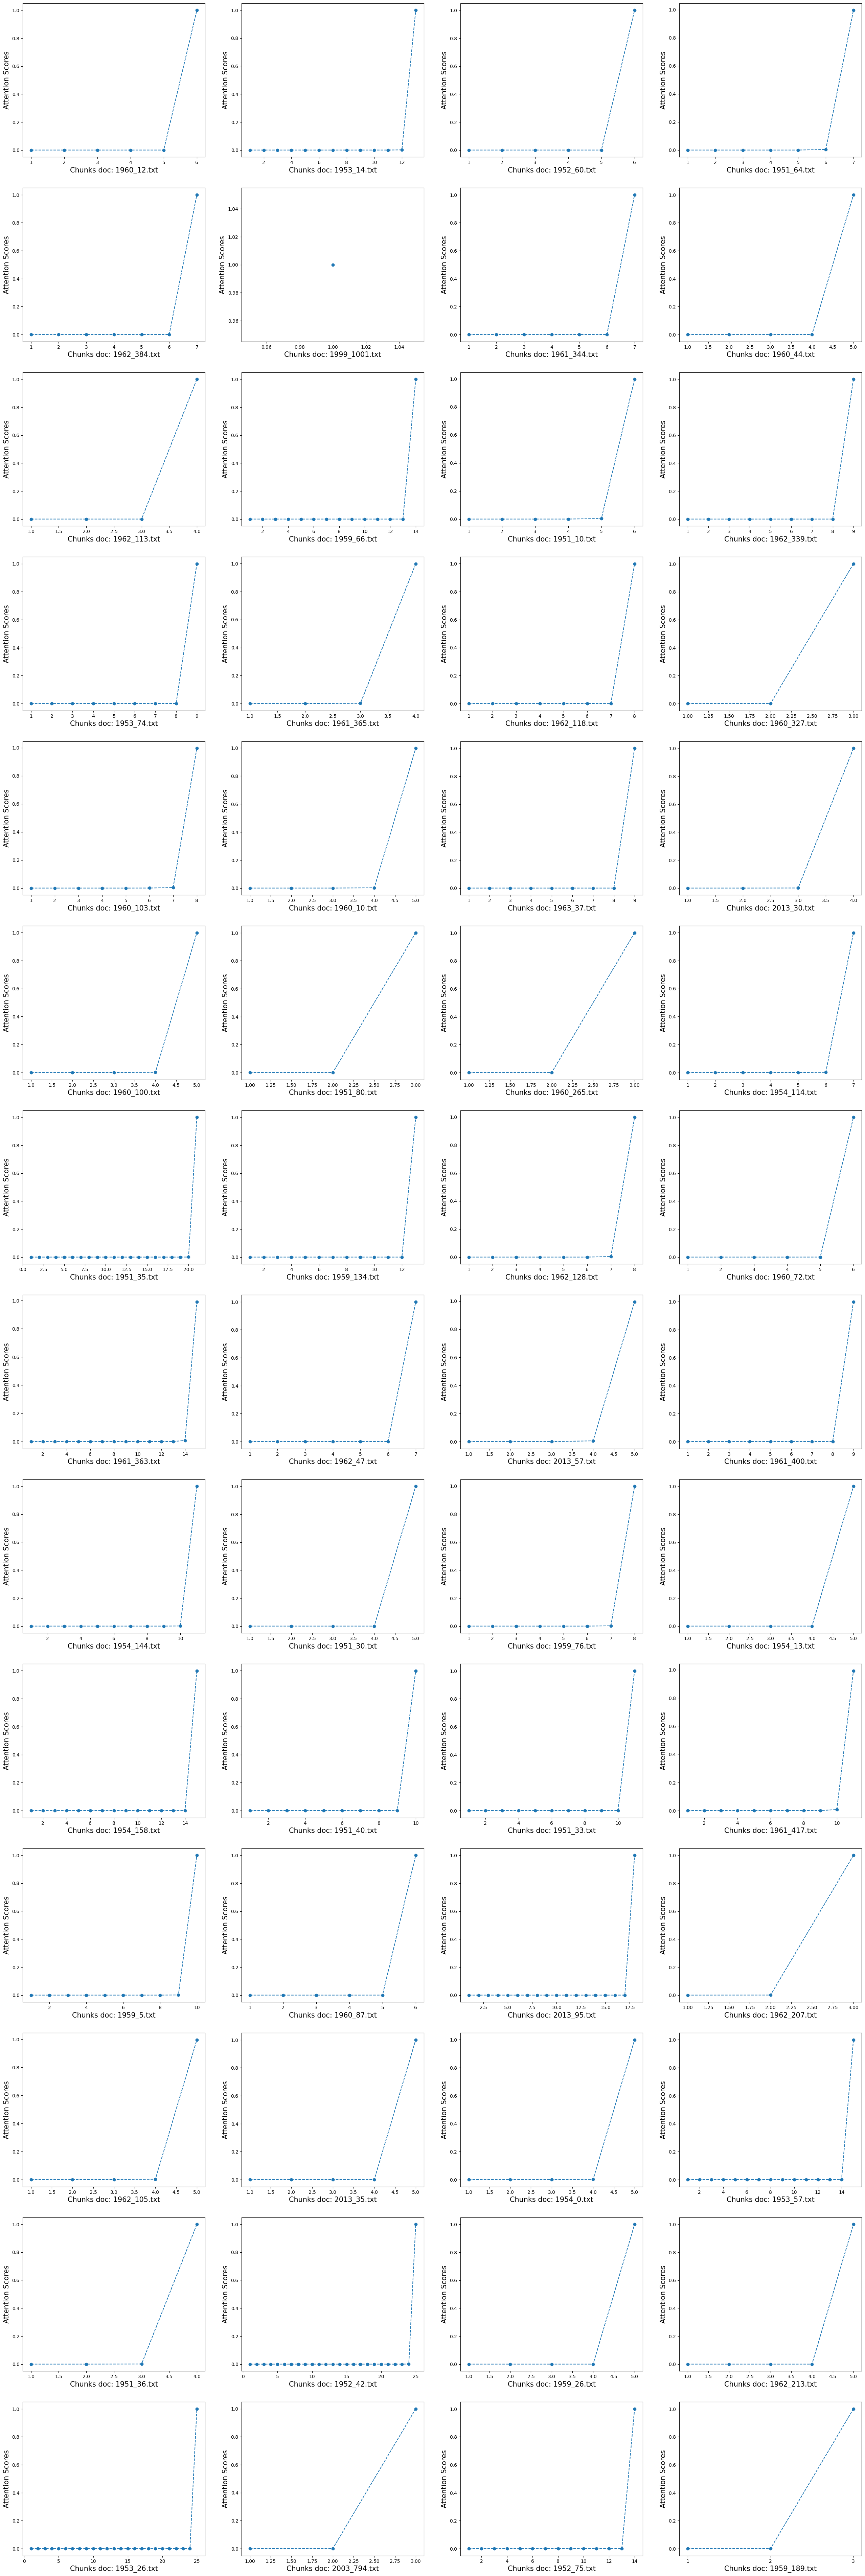

In [29]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(14, 4, figsize=(32, 98))
l=0
r=0
for i, sc in enumerate(wt_vector_flat):
  plt.xticks(list(range(1,len(sc)+1,1)))

  y = list(range(1,len(sc)+1,1))
  axs[l,r].plot(y, sc, marker='o', linestyle='dashed')
  axs[l,r].set_xlabel('Chunks doc: '+ test.iloc[i]['name'],fontsize = 15.0)
  axs[l,r].set_ylabel('Attention Scores',fontsize = 15.0)


  r+=1
  if(r==4):
    l+=1
    r=0

plt.savefig('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/only_annotation/attention_anno_full/att_scores_anno_full.png', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Thesis/Models_whole_data/case_explanation_caselawbert/only_annotation/attention_anno_full/att_scores_anno_full.eps', format='eps', bbox_inches='tight')